In [247]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import heapq as hq

In [248]:
# 计算方差窗口的大小
def computeWinSize(length, b):
    if 0 < length <= b:
        return 1
    else:
        return length // b

In [249]:
# 计算标准差数组
def computeStdArr(series, b):
    l = len(series)
    # 窗口下取整
    w = computeWinSize(l, b)
    # print(w)
    res = []
    for i in range(w, l - w):
        win_arr = [0 for i in range(2 * w + 1)]
        cnt = 0
        for j in range(i - w, w + i + 1):
            win_arr[cnt] = series[j]
            cnt += 1
        std = np.std(win_arr, ddof=0)
        res.append(std)
    return res

In [250]:
# 选择L*α最大的点的下标,，保留下标
def selectLargePoint(series, a):
    l = len(series)
    # 生成l*a个
    res = hq.nlargest(int(l * a), range(l), key=lambda x: series[x])
    return res

In [251]:
# 判断是否为波峰波谷
def isPeakOrValley(std_arr, index, b):
    win_size = computeWinSize(len(std_arr), b)
    flag = False
    if win_size == 1:
        if ((std_arr[index] > std_arr[index - 1] and std_arr[index] > std_arr[index + 1]) or (
                std_arr[index] < std_arr[index - 1] and std_arr[index] < std_arr[index + 1])):
            flag = True
    elif win_size == 2:
        if ((std_arr[index] >= std_arr[index - 1] and std_arr[index] > std_arr[index - 2] and std_arr[index] >= std_arr[
            index + 1] and std_arr[index] > std_arr[index + 2])
                or
                (std_arr[index] <= std_arr[index - 1] and std_arr[index] < std_arr[index - 2] and std_arr[index] <=
                 std_arr[
                     index + 1]) and std_arr[index] < std_arr[index + 2]):
            flag = True
    elif win_size == 3:
        if ((std_arr[index] >= std_arr[index - 1] and std_arr[index] > std_arr[index - 2] and std_arr[index] > std_arr[
            index - 3]
             and std_arr[index] >= std_arr[index + 1] and std_arr[index] > std_arr[index + 2] and std_arr[index] >
             std_arr[
                 index + 3])
                or
                (std_arr[index] <= std_arr[index - 1] and std_arr[index] < std_arr[index - 2] and std_arr[index] <
                 std_arr[index - 3]) and std_arr[index] <= std_arr[index + 1] and std_arr[index] < std_arr[
                    index + 2] and std_arr[index] < std_arr[index + 3]):
            flag = True
    elif win_size == 4:
        if ((std_arr[index] >= std_arr[index - 1] and std_arr[index] > std_arr[index - 2] and std_arr[index] > std_arr[
            index - 3] and std_arr[index] > std_arr[index - 4]
             and std_arr[index] >= std_arr[index + 1] and std_arr[index] > std_arr[index + 2] and std_arr[index] >
             std_arr[
                 index + 3] and std_arr[index] > std_arr[index + 4])
                or
                (std_arr[index] <= std_arr[index - 1] and std_arr[index] < std_arr[index - 2] and std_arr[index] <
                 std_arr[
                     index - 3] and std_arr[index] < std_arr[index - 4]
                 and std_arr[index] <= std_arr[index + 1] and std_arr[index] < std_arr[index + 2] and std_arr[index] <
                 std_arr[index + 3] and std_arr[index] < std_arr[index + 4])):
            flag = True
    else:
        if ((std_arr[index] > std_arr[index - 1] and std_arr[index] > std_arr[index - 2] and std_arr[index] > std_arr[
            index - 3] and std_arr[index] > std_arr[index - 4] and std_arr[index] > std_arr[index - 5]
             and std_arr[index] > std_arr[index + 1] and std_arr[index] > std_arr[index + 2] and std_arr[index] >
             std_arr[
                 index + 3] and std_arr[index] > std_arr[index + 4] and std_arr[index] > std_arr[index + 5])
                or
                (std_arr[index] < std_arr[index - 1] and std_arr[index] < std_arr[index - 2] and std_arr[index] <
                 std_arr[
                     index - 3] and std_arr[index] < std_arr[index - 4] and std_arr[index] < std_arr[index - 5]
                 and std_arr[index] < std_arr[index + 1] and std_arr[index] < std_arr[index + 2] and std_arr[index] <
                 std_arr[
                     index + 3] and std_arr[index] < std_arr[index + 4] and std_arr[index] < std_arr[index + 5])):
            flag = True
    return flag



In [252]:
# 找到所有合适的区间
def fitPoint(stdA, indexA, b):
    w = computeWinSize(len(stdA), b)
    l = len(indexA)
    res = []
    for i in range(0, l):
        val = indexA[i]
        if w <= val < l - w:
            if isPeakOrValley(stdA, val, b):
                res.append(val + 2 * w + 1)
    return res

In [253]:
# 提取特征关键点
def extractFeaturePoint(arr, a, b):
    stdArrOne = computeStdArr(arr, b)
    largePoint = selectLargePoint(stdArrOne, a)
    indexArr = fitPoint(stdArrOne, largePoint, b)
    return indexArr

In [254]:
# 判断有几个关键点与它相近
def closeNums(keyList,key,threshold):
    cnt = 0
    cnt += keyList.count(key)
    for i in range(1,threshold):
        a = key + i
        b = key - i
        cnt += keyList.count(a)
        cnt += keyList.count(b)
    return cnt

In [255]:
class keyPoint:
    def __init__(self,key,cnt,dim):
        self.key = key
        self.cnt = cnt
        self.dim = dim

In [256]:
class smallKeyPoint:
    def __init__(self,key,dim):
        self.key = key
        self.dim = dim

In [257]:
# 找到较为相近的关键点
def selectKeys(data,alp,blt,howclose=2):
    # 原始data顺序 样本数 维度数 序列长度
    dim_nums = data.shape[1]
    sample_nums = data.shape[0]
    all_keys = []
    for sm in tqdm(range(sample_nums)):
        one_sample  = data[sm]
        # 每个维度的关键点下标集合
        key_points = []
        # 所为维度下的关键点下标
        ex_key_points = []
        for dn in range(dim_nums):
            # keys 关键点的下标
            keys = extractFeaturePoint(one_sample[dn],alp,blt)
            key_points.append(keys)
        # 有一部分在构建的序列上

        for dn in range(dim_nums):
            # 一个维度上的关键下标
            kl = key_points[dn]
            # 去掉自己维度的下标
            tmp_key_points = key_points[:]
            tmp_key_points.remove(kl)
            key_list = []
            for i in tmp_key_points:
                key_list.extend(i)

            ekl = []
            for k in kl:
                cnt = closeNums(key_list,k,howclose)
                ekl.append(keyPoint(k,cnt,dn))
            ex_key_points.extend(ekl)

        ex_key_points.sort(key=lambda x:x.cnt,reverse=True)
        # 筛选
        res_keys = ex_key_points[:]
        res = 0
        for k in res_keys:
            if k.cnt >= res_keys[0].cnt * 0.9:
                res += 1
        res_keys = res_keys[:res]
        all_keys.append(res_keys)
    return all_keys

In [258]:
class shapelet:
    def __init__(self,keyPoint,ylt,st,ed,length,val,sample):
        # keyPoint 由那个keyPoint生成
        # ylt 松弛是多少
        # st 起始位置
        # ed 终止位置
        # val shapelet在序列中的实际的值
        self.quality = None
        self.keyPoint = keyPoint
        self.ylt = ylt
        self.st = st
        self.ed = ed
        self.length = length
        self.val = val
        self.sample = sample
    def setQuality(self,quality):
        self.quality = quality

In [259]:
def generateCandidates(s,sm,l,keyP,ylt):
    # sm 为单个样本[维度，长度]
    # keyP 应该为一个keyPoint
    # ylt为松弛参数
    candidate = []
    if l % 2 == 1:
        l = l // 2
        dim = keyP.dim
        s = s[dim]
        for i in range(-ylt,ylt+1):
            # 从中心点两侧的松弛长度进行计算
            if keyP.key - i - l < 0:
                continue
            left = keyP.key - i - l
            if keyP.key - i + l + 1 >= len(s):
                continue
            right = keyP.key - i + l + 1
            spt = shapelet(keyPoint=keyP,ylt=ylt,st=left,ed=right - 1,length=right-left,val=s[left:right],sample=sm)
            candidate.append(spt)
    else:
        l = l // 2
        dim = keyP.dim
        s = s[dim]
        for i in range(-ylt,ylt+1):
            # 从中心点两侧的松弛长度进行计算
            if keyP.key - i - l < 0:
                continue
            left = keyP.key - i - l
            if keyP.key - i + l >= len(s):
                continue
            right = keyP.key - i + l
            spt = shapelet(keyPoint=keyP,ylt=ylt,st=left,ed=right - 1,length=right-left,val=s[left:right],sample=sm)
            candidate.append(spt)
            if keyP.key - i - l + 1< 0:
                continue
            left = keyP.key - i - l + 1
            if keyP.key - i + l + 1 >= len(s):
                continue
            right = keyP.key - i + l + 1
            spt = shapelet(keyPoint=keyP,ylt=ylt,st=left,ed=right - 1,length=right-left,val=s[left:right],sample=sm)
            candidate.append(spt)
    return candidate

In [260]:
import collections
def findShapeletCandidates(data,lmin,lmax,keys,ylt,odim):
    sample_nums = data.shape[0]
    candidate = []
    for sm in tqdm(range(sample_nums)):
        s = data[sm]
        keyList = keys[sm]
        for k in keyList:
            # lmin - lmax
            for l in range(lmin,lmax+1):
                candidate.extend(generateCandidates(s,sm,l,k,ylt))
    # print(len(candidate))
    dt = collections.defaultdict(list)
    for cd in candidate:
        dt[cd.length].append(cd)

    # 对dt进行剪枝
    v = dt.keys()
    # print(len(dt[3]))

    # 对于每个长度
    for k in v:
        ls = dt[k]
        tmpls = []
    #     每个维度都选几个
        res = collections.defaultdict(list)
        for i in ls:
            # print(type(i))
            res[i.keyPoint.dim].append(i)
        dims = list(res.keys())

        org_dim_list = []
        convert_dim_list = []
        for i in dims:
            if i >= odim:
                convert_dim_list.append([i,len(res[i])])
            else:
                org_dim_list.append([i,len(res[i])])


        convert_dim_list.sort(key = lambda x:x[1],reverse=True)
        org_dim_list.sort(key = lambda x:x[1],reverse=True)

        convert_pre_dim = int(len(convert_dim_list) * 0.3)
        convert_pre_dims = convert_dim_list[:convert_pre_dim + 1]
        convert_aft_dims = convert_dim_list[convert_pre_dim + 1:]
        if len(convert_pre_dims) > 1:
            convert_pre_dims = random.sample(convert_pre_dims,int(convert_pre_dim * 0.7))
        if len(convert_aft_dims) > 1:
            convert_aft_dims = random.sample(convert_aft_dims,int(len(convert_aft_dims) * 0.3))
        # print(convert_pre_dims,convert_aft_dims)


        org_pre_dim = int(len(org_dim_list) * 0.3)
        org_pre_dims = org_dim_list[:org_pre_dim + 1]
        org_aft_dims = org_dim_list[org_pre_dim + 1:]
        if len(org_pre_dims) > 1:
            org_pre_dims = random.sample(org_pre_dims,int(org_pre_dim * 0.7))
        if len(org_aft_dims) > 1:
            org_aft_dims = random.sample(org_aft_dims,int(len(org_aft_dims) * 0.3))

        # 选择数量较多的维度
        # 前30%为维度选择70% 后70%维度选择30%
        # pre_dim = int(len(dims) * 0.3)
        # pre_dims = dims[:pre_dim + 1]
        # aft_dims = dims[pre_dim + 1:]
        # # 70%
        # pre_dims = random.sample(pre_dims,int(pre_dim * 0.7))
        # aft_dims = random.sample(aft_dims,int(len(aft_dims) * 0.3))
        # dims = convert_pre_dims + convert_aft_dims + org_pre_dims + org_aft_dims
        dims_list = convert_pre_dims + convert_aft_dims + org_pre_dims + org_aft_dims
        dims = []
        for i in dims_list:
            dims.append(i[0])
        # print("777777777777777777777777777777777777")
        # print(dims)
        # 筛选维度
        for i in dims:
            tmp = res[i]
            # 尽量选取每个样本
            newdt = collections.defaultdict(list)
            for x in tmp:
                newdt[x.sample].append(x)
            klist = list(newdt.keys())

            indx = 0
            smp = []
            while len(smp) <= min(50,len(tmp)):
                index = klist[indx]
                indx = (indx + 1) % len(klist)
                rc = random.choice(newdt[index])
                while rc in smp:
                    rc = random.choice(newdt[index])
                smp.append(rc)
            # smp = random.sample(tmp,min(50,len(tmp)))
            tmpls.extend(smp)



        # # # 取每个维度的前1000
        # for i in dims:
        #     tmp = res[i]
        #     # 尽量选取每个样本
        #     newdt = collections.defaultdict(list)
        #     for x in tmp:
        #         newdt[x.sample].append(x)
        #     klist = list(newdt.keys())
        #
        #     indx = 0
        #     smp = []
        #     while len(smp) <= min(50,len(tmp)):
        #         index = klist[indx]
        #         indx = (indx + 1) % len(klist)
        #         rc = random.choice(newdt[index])
        #         while rc in smp:
        #             rc = random.choice(newdt[index])
        #         smp.append(rc)
        #     # smp = random.sample(tmp,min(50,len(tmp)))
        #     tmpls.extend(smp)
        dt[k] = tmpls
    return dt


In [261]:
# import collections
# def findShapeletCandidates(data,lmin,lmax,keys,ylt):
#     sample_nums = data.shape[0]
#     candidate = []
#     for sm in tqdm(range(sample_nums)):
#         s = data[sm]
#         keyList = keys[sm]
#         for k in keyList:
#             # lmin - lmax
#             for l in range(lmin,lmax+1):
#                 candidate.extend(generateCandidates(s,sm,l,k,ylt))
#     # print(len(candidate))
#     dt = collections.defaultdict(list)
#     for cd in candidate:
#         dt[cd.length].append(cd)
#
#     # 对dt进行剪枝
#     v = dt.keys()
#     # 对于每个长度
#     for k in v:
#         ls = dt[k]
#         tmpls = []
#     #     每个维度都选几个
#         res = collections.defaultdict(list)
#         for i in ls:
#             # print(type(i))
#             res[i.keyPoint.dim].append(i)
#         dims = res.keys()
#         # 取每个维度的前1000
#         for i in dims:
#             tmp = res[i]
#             smp = random.sample(tmp,min(50,len(tmp)))
#             tmpls.extend(smp)
#         dt[k] = tmpls
#     return dt


In [262]:
def findDistances(c,l,data):
    # 查找获选shapelet在每个样本上的最小值
    ds = []
    dim = c.keyPoint.dim
    data = np.transpose(data,axes=(1,0,2))
    sers = data[dim]
    for s in sers:
        cp = [s[i : i + l] for i in range(0, len(s)-l+1, 1)]
        ds.append(cdist([c.val],cp,metric='seuclidean').min())
    return np.array(ds)

In [263]:
def assessCandidate(ds,label):
    class_groups = []
    for c in np.unique(label):
        class_groups.append(ds[label==c].tolist())
#  返回f值
    return f_oneway(*class_groups).statistic

In [264]:
def sortByQuality(shapelets):
    return sorted(shapelets, key=lambda s: s.quality,reverse=True)

In [265]:
class interval:
    def __init__(self,st,ed):
        self.st = st
        self.ed = ed
    def isInclude(self,a):
        # 是否被a包含
        if self.st >= a.st and self.ed <= a.ed:
            return True


In [266]:
def removeSelfSimilar(shapelets):
    ts = shapelets[:][::-1]
    it = []
    for x in ts:
        it.append(interval(x.st,x.ed))
    removeIdx = []
    l = len(it)
    # 修改将重叠改为包含
    for i in range(l):
        for j in range(i+1,l):
            if it[i].isInclude(it[j]):
                removeIdx.append(i)
                break
    res = []
    for i in range(l):
        if i not in removeIdx:
            res.append(ts[i])


    return res[::-1]

In [267]:
def merge(k,kShapelets,shapelets):
    total_shapelets = kShapelets + shapelets
    return sortByQuality(total_shapelets)[:k]

In [268]:
def findShapelets(data,label,dt,k):
    kShapelets = []
    # l 为长度
    for l in dt.keys():
        # cd 是单个长度的所有样本和维度下的shaplet候选
        cd = dt[l]
        if len(cd) == 0:
            continue
        for i,c in enumerate(tqdm(cd)):
            ds = findDistances(c,l,data)
            quality = assessCandidate(ds,label)
            cd[i].setQuality(quality)
        cd = sortByQuality(cd)
        # print(len(cd))
        cd = removeSelfSimilar(cd)
        # print(len(cd))
        kShapelets = merge(k,kShapelets,cd)
    return kShapelets
        # print(len(cd))
        # print(cd[0].quality,cd[1].quality,cd[-1].quality)
    # print(k)

In [269]:
# np.vstack([[2,3,4,5],[1,2,3,4],[1,2,3,5]])

In [270]:
# a = cdist([[1,2,3,4]],[[2,3,4,10],[1,2,3,4],[1,2,3,5]],metric='euclidean').min()
# print(a)

In [271]:
# def SelectShapelet(data,label,lmin,lmax,alp,blt,ylt):
#     # 原始data顺序 样本数 维度数 序列长度
#     data = np.transpose(data,axes=(1,0,2))
#     # 现在data顺序 维度数 样本数 序列长度
#     dim_nums = data.shape[0]
#     sample_nums = data.shape[1]
#     for dn in tqdm(range(dim_nums)):
#         T = data[dn]
#         keyPoints = []
#         for sm in range(sample_nums):
#             keyPoints.append(extractFeaturePoint(data[dn][sm],alp,blt))
#
#
#
#
#
#
#         # print(keyPoints)
#         precompute_Wl = {l : create_Wl(T,l,keyPoints,sample_nums,ylt) for l in np.arange(lmin,lmax+1)}
#
#         kShapelets = []
#         for i,Ti in enumerate(T):
#             shapelets = []
#             for l in np.arange(lmin,lmax+1):
#                 # S为所有的长度
#                 Al = precompute_Wl[l]
#                 Wl,Pl = Al[0],Al[1]
#                 for index,S in enumerate(Wl[i]):
#                      # 和所有样本上的候选者比较
#                     #  S 区间，keypoint，松弛长度
#                     # Ds,Indx = findDistances(S,Wl)
#
#                     Ds = findDistances(S,Wl)
#                     quality = assessCandidate(Ds,label)
#                     #  区间值 度量  区间 关键点
#                     shapelets.append((S,quality,pd.Interval(Pl[index][1],Pl[index][2]-1,closed='both'),Pl[index][0]))
#             shapelets = sortByQuality(shapelets)
#             shapelets = removeSelfSimilar(shapelets)
#             kShapelets = merge(k,kShapelets,shapelets)
#         print(kShapelets)
#
#
#
#
#
#
#


In [272]:
def load_raw_ts(path, dataset):
    path = path + "raw//" + dataset + "//"
    # 训练集
    x_train = np.load(path + 'X_train.npy')
    x_train = np.transpose(x_train, axes=(0, 2, 1))
    x_test = np.load(path + 'X_test.npy')
    x_test = np.transpose(x_test, axes=(0, 2, 1))
    y_train = np.load(path + 'y_train.npy')
    y_test = np.load(path + 'y_test.npy')
    labels = np.concatenate((y_train, y_test), axis=0)
    nclass = int(np.amax(labels)) + 1
    return x_train, x_test, y_train.reshape(-1), y_test.reshape(-1), nclass

In [273]:
# target_train 为标签 data_train 为序列
data_train, data_test, target_train, target_test, nclass = load_raw_ts("D://tmppro//data//", "FingerMovements")
sample_nums = data_train.shape[0]
dim_nums = data_train.shape[1]
series_length = data_train.shape[2]
test_nums = data_test.shape[0]

In [274]:
import random

lmin = 3
lmax = 13
# 选取shapelet的数量
k = int(series_length * dim_nums)
alp = 0.3
# k = 20
# alp = random.choice([0.3, 0.4])
# blt = random.choice([100, 90, 80, 70, 60, 50])
blt = 100
# ylt = random.choice([5,6,7,8])
ylt = 8
dis = 2

In [275]:
print(k)

1400


In [276]:
#对于每个样本生成差异序列序列
def genDiffSeries(data):
    sample_nums = data.shape[0]
    dim_nums = data.shape[1]
    series_length = data.shape[2]
    gen_data = []
    for sn in range(sample_nums):
        sm = data[sn]
        res = []
        # 先将原始的每个维度的加进入
        for i in range(dim_nums):
            res.append(sm[i])
        # 再计算每个减法维度，然后依次加进去
        for i in range(dim_nums-1):
            for j in range(i+1,dim_nums):
                s1 = sm[i]
                s2 = sm[j]
                news = [0 for _ in range(series_length)]
                for k in range(series_length):
                    news[k] = s1[k] - s2[k]
                res.append(np.array(news))
        gen_data.append(np.array(res))
    return np.array(gen_data)

In [277]:
print(data_train.shape)
a = genDiffSeries(data_train)
print(a.shape)


(316, 28, 50)
(316, 406, 50)


In [278]:
keys = selectKeys(a,alp,blt,2)

100%|██████████| 316/316 [03:04<00:00,  1.71it/s]


In [279]:
dt = findShapeletCandidates(a,lmin,lmax,keys,ylt,dim_nums)

100%|██████████| 316/316 [00:38<00:00,  8.25it/s]


In [280]:
kshapelets = findShapelets(a,target_train,dt,k)
k = len(kshapelets)

100%|██████████| 8568/8568 [03:42<00:00, 38.47it/s]


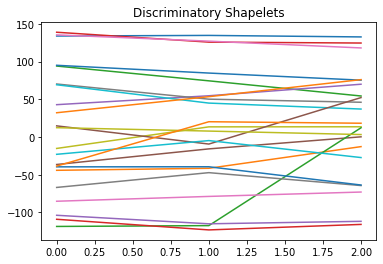

In [281]:
for shape in kshapelets:
    if shape.length == 3:
        plt.plot(shape.val)
plt.title("Discriminatory Shapelets")
plt.show()

搞个判断标准，选择较好的候选shapelet

In [282]:
dataset = np.zeros((sample_nums,k))
for i,sp in enumerate(tqdm(kshapelets)):
    Ds = findDistances(sp,sp.length,a)
    dataset[:,i] = Ds
dataset = np.nan_to_num(dataset)
# print(dataset)

100%|██████████| 217/217 [00:05<00:00, 38.01it/s]


In [283]:
dataset_test = np.zeros((test_nums,k))
b = genDiffSeries(data_test)
for i,sp in enumerate(tqdm(kshapelets)):
    Ds = findDistances(sp,sp.length,b)
    dataset_test[:,i] = Ds
dataset_test = np.nan_to_num(dataset_test)

100%|██████████| 217/217 [00:01<00:00, 121.30it/s]


In [284]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [285]:
sc = StandardScaler()
# scc = sc.fit_transform(dataset)
# np.set_printoptions(threshold=np.inf)
# print(dataset)
# print(scc)

# model = LogisticRegressionCV(max_iter=100000).fit(sc.fit_transform(dataset),target_train)
model = LinearSVC(max_iter=100000).fit(sc.fit_transform(dataset),target_train)

In [286]:
print(classification_report(target_train,model.predict(sc.transform(dataset))))
print(accuracy_score(target_train,model.predict(sc.transform(dataset))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00       157

    accuracy                           1.00       316
   macro avg       1.00      1.00      1.00       316
weighted avg       1.00      1.00      1.00       316

1.0


In [287]:
print(classification_report(target_test,model.predict(sc.transform(dataset_test))))
print(accuracy_score(target_test,model.predict(sc.transform(dataset_test))))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55        49
           1       0.55      0.47      0.51        51

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.53      0.53      0.53       100

0.53


todo:
优先选择样本产生多的？？